In [1]:
import time
# get_ipython().run_line_magic('matplotlib', 'inline')
# import matplotlib.pyplot as plt
# get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import statsmodels.api as sm
from sklearn import preprocessing 
import ema_workbench.em_framework.evaluators
import matplotlib.pyplot as plt

In [2]:
import os
from dest_directories import gz_path, fig_path
from dicemodel.noDICE_v7 import PyDICE
model_version = 'v7'

from dicemodel.specs import nordhaus_policy, reference_scenario, change_fontsize

In [3]:
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, TimeSeriesOutcome, ScalarOutcome, ArrayOutcome, Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
from ema_workbench import save_results, load_results
from ema_workbench.analysis import prim, cart
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis import plotting, plotting_util, pairs_plotting, parcoords

ema_logging.log_to_stderr(ema_logging.INFO)

model = PyDICE()
dice_sm = Model('dicesmEMA', function=model)

In [4]:
dice_opt = pd.read_excel("DICE2013R.xlsm" ,sheet_name = "Opttax", index_col = 0)


## Directed search: Worst Case Scenario

In [5]:
dice_sm.uncertainties = [
                            # IntegerParameter('t2xco2_index', 0, 999),
                            #  IntegerParameter('t2xco2_dist',0,2),
                            #  IntegerParameter('fdamage', 0, 2),
                             RealParameter('tfp_gr',  0.07, 0.09),
                             RealParameter('sigma_gr', -0.012, -0.008),
                             RealParameter('pop_gr', 0.1, 0.15),
                             RealParameter('fosslim',  4000.0, 13649),
                             IntegerParameter('cback', 100, 600),
                             RealParameter('emdd', -1, 0.99),
                             IntegerParameter('vd_switch', 0, 1),
                            ]
    
dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                      RealParameter('prtp_con',  0.001, 0.015),
                      RealParameter('emuc', 1.01, 2.00),
                      IntegerParameter('periodfullpart', 10, 58),
                      IntegerParameter('miu_period', 10, 58)
                      ]


                        
dice_sm.outcomes = [
            ScalarOutcome('Atmospheric Temperature 2300', kind=ScalarOutcome.MINIMIZE),
            ScalarOutcome('Total Output 2300', kind=ScalarOutcome.MAXIMIZE),
            ScalarOutcome('Per Capita Consumption 2300', kind=ScalarOutcome.INFO),
            ScalarOutcome('Consumption Growth 2300', kind=ScalarOutcome.INFO),
            ScalarOutcome('Utility of Consumption 2300', kind=ScalarOutcome.MAXIMIZE),
            ScalarOutcome('Per Capita Damage 2300', kind=ScalarOutcome.INFO),
            ScalarOutcome('Damage Growth 2300', kind=ScalarOutcome.INFO),
            ScalarOutcome('Disutility of Damage 2300', kind=ScalarOutcome.MINIMIZE),
            ScalarOutcome('Welfare 2300', kind=ScalarOutcome.MAXIMIZE),
            # ScalarOutcome('Undiscounted Period Welfare 2300', kind=ScalarOutcome.INFO),
            # ScalarOutcome('Consumption SDR 2300', kind=ScalarOutcome.INFO),
            # ScalarOutcome('Damage SDR 2300', kind=ScalarOutcome.INFO),
            ScalarOutcome('Mean SCC 2300', kind=ScalarOutcome.INFO)
            ]


In [6]:
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import EpsilonProgress

BaseEvaluator.reporting_frequency = 0.1

In [7]:
nord_optimal_policy = Policy('nord_optimal_policy', **nordhaus_policy(np.mean(dice_opt.iloc[129]),prtp_con =0.015,emuc=1.45, miu_period= 0, periodfullpart=29 ))  # vd_switch=1
nord_optimal_policy

Policy({'sr': 0.24868248835166676, 'prtp con': 0.015, 'emuc': 1.45, 'periodfullpart': 29, 'miu_period': 0})

In [8]:
eps = [0.0001] * (int(len(dice_sm.outcomes)))
convergence_metrics = [EpsilonProgress()]

In [11]:

nfe = 100000

run = 'run_37_Nord_WCS_' 
#  run 15 with V(D) minimize,min and max limits to V(D) are both zer0. Probably only keeps V(D) switch off outcomes 
#  run 16: V(D) and U(C) set to info. has SDRs, U(C), V(D) min & max NaN, Temp min & max both 0
# run 17: same as run 16, but without the SDRs. Still trying to figure this out. Ah okay, convergence savefile was overwriting results. Let's see what happens now. only one result row
# run 17b: changed eps to 0.0001, turned convergence off
# run 18: eps 0.01
# run 19: turned convergence back on. forgot to add convergence var in evaluator
# run 20: addad conv in eval
# run 21: removing all .info, converting into max or min. Looks good, but only 5 outcomes
# run 22: eps = 0.001
# run 23: eps = 0.0001, vd_switch always 1 (putting it into levers)
# run 24: model v7 (t2xco2 removed)
# run 35: model v7.2 ------wrong emdd range
# run 36: corrected emdd range
# run 37: WCS, eps = 0.0001


In [9]:

for outcome in dice_sm.outcomes:
    if not outcome.kind == ScalarOutcome.INFO:
            if outcome.kind == ScalarOutcome.MINIMIZE:
                outcome.kind = ScalarOutcome.MAXIMIZE
            else:
                outcome.kind = ScalarOutcome.MINIMIZE
    print(outcome, outcome.kind)
#  How do I get the .INFO outcomes to show in the WCS 

ScalarOutcome('Atmospheric Temperature 2300') 1
ScalarOutcome('Total Output 2300') -1
ScalarOutcome('Utility of Consumption 2300') -1
ScalarOutcome('Disutility of Damage 2300') 1
ScalarOutcome('Welfare 2300') -1


In [12]:
start = time.time()
print("starting search for wcs", flush=True)
with MultiprocessingEvaluator(dice_sm, n_processes=16) as evaluator:
    results, convergence = evaluator.optimize(
        nfe=nfe,
        searchover='uncertainties',
        reference=nord_optimal_policy,
        epsilons=eps,
        convergence=convergence_metrics
        )
                                                

results.to_csv(os.path.join(gz_path, str(run) +'_v7_results' +  '.csv'))
convergence.to_csv(os.path.join(gz_path, str(run) + '_v7_convergence' +  '.csv'))

end = time.time()
print('Directed Search of WCS time is ' + str(round((end - start) / 60)) + ' mintues')

starting search for wcs
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/100000 nfe
[MainProcess/INFO] generation 5: 500/100000 nfe
[MainProcess/INFO] generation 10: 1000/100000 nfe
[MainProcess/INFO] generation 15: 1500/100000 nfe
[MainProcess/INFO] generation 20: 2000/100000 nfe
[MainProcess/INFO] generation 25: 2500/100000 nfe
[MainProcess/INFO] generation 30: 3000/100000 nfe
[MainProcess/INFO] generation 35: 3500/100000 nfe
[MainProcess/INFO] generation 40: 4000/100000 nfe
[MainProcess/INFO] generation 45: 4500/100000 nfe
[MainProcess/INFO] generation 50: 5000/100000 nfe
[MainProcess/INFO] generation 55: 5500/100000 nfe
[MainProcess/INFO] generation 60: 6000/100000 nfe
[MainProcess/INFO] generation 65: 6500/100000 nfe
[MainProcess/INFO] generation 70: 7000/100000 nfe
[MainProcess/INFO] generation 75: 7500/100000 nfe
[MainProcess/INFO] generation 80: 8000/100000 nfe
[MainProcess/INFO] generation 85: 8500/100000 nfe
[MainProcess/INFO] generation 90: 9000/100000 nfe


In [16]:
# results = pd.read_csv(os.path.join(gz_path, 'run_21_Nord_WCS_v6_nfe100000_eps[0.01, 0.01, 0.01, 0.01, 0.01, 0.01]_results.csv'))
# results = results.drop(results.columns[0], axis = 1)


In [13]:
results

,tfp_gr,sigma_gr,pop_gr,fosslim,cback,emdd,vd_switch,Atmospheric Temperature 2300,Total Output 2300,Utility of Consumption 2300,Disutility of Damage 2300,Welfare 2300
0,0.075028,-0.008383,0.100034,8341.203332,600,0.221882,1,0.0,2773.089462,1.016783,1.000000e-05,-3854.719000
1,0.077365,-0.008015,0.100011,7242.288058,600,0.512220,1,0.0,2770.894560,1.016710,1.000000e-05,-3854.718701
2,0.089180,-0.008000,0.100004,8313.496168,129,0.851346,1,0.0,2790.646520,1.017366,1.000000e-05,-3854.758006
3,0.077082,-0.008000,0.100005,7793.841966,247,0.444700,1,0.0,2785.670650,1.017201,1.000000e-05,-3854.734849
4,0.077264,-0.008000,0.100000,12281.005917,150,0.589027,0,0.0,2789.760147,1.017337,1.000000e-11,-3854.753854
5,0.075915,-0.008012,0.100034,8866.091375,188,0.965702,1,0.0,2788.188254,1.017285,1.000000e-05,-3854.747199
6,0.086505,-0.008000,0.100001,8214.087153,194,0.186682,1,0.0,2787.905255,1.017275,1.000000e-05,-3854.746018
7,0.075985,-0.008000,0.100000,8181.411604,206,0.362150,1,0.0,2787.398331,1.017259,1.000000e-05,-3854.743606
8,0.078020,-0.008000,0.100000,8802.376635,277,0.558694,1,0.0,2784.404996,1.017160,1.000000e-05,-3854.727899
9,0.075536,-0.008000,0.100000,6928.842651,267,0.167314,1,0.0,2784.826533,1.017174,1.000000e-05,-3854.730269


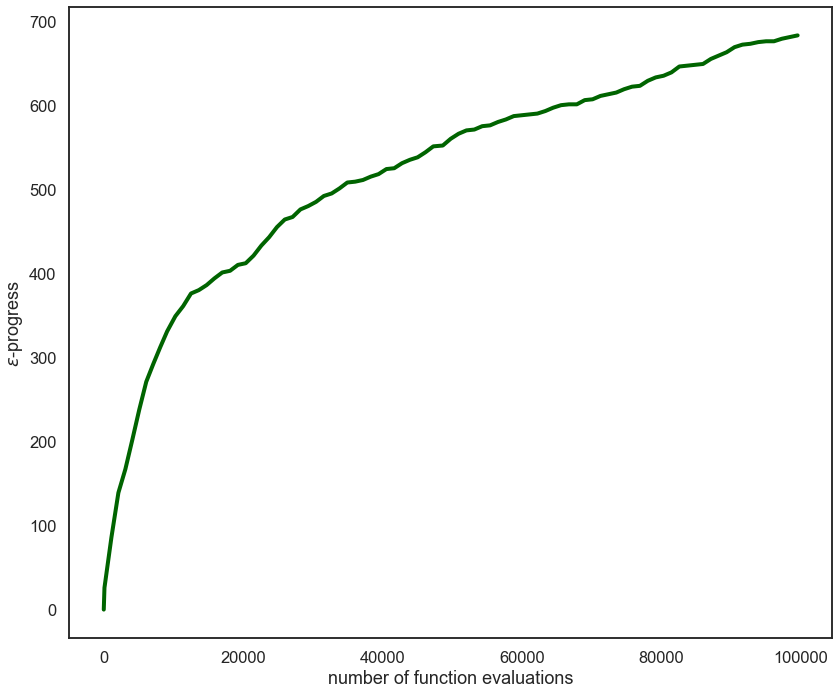

In [14]:
sns.set_context("talk")
plt.figure(figsize=(12,10))
plt.plot(convergence.nfe, convergence.epsilon_progress, color = "darkgreen", linewidth=4)
plt.ylabel('$\epsilon$-progress')
plt.xlabel('number of function evaluations')
plt.tight_layout()
plt.savefig(os.path.join(fig_path, str(run) + 'DSearch_convergence' + '.png'),bbox_inches='tight')

In [15]:
data = results.loc[:, [o.name for o in dice_sm.uncertainties]]
limits = parcoords.get_limits(data)
limits

,tfp_gr,sigma_gr,pop_gr,fosslim,cback,emdd,vd_switch
0,0.070036,-0.010121,0.100000,4531.080335,100,-0.999885,0
1,0.089389,-0.008000,0.100929,13622.048073,600,0.989997,1


In [16]:
data_outcomes = results.loc[:, [o.name for o in dice_sm.outcomes]]
print(data_outcomes.idxmax())
print(data_outcomes.idxmin())

Atmospheric Temperature 2300      0
Total Output 2300                40
Utility of Consumption 2300      40
Disutility of Damage 2300         0
Welfare 2300                    153
dtype: int64
Atmospheric Temperature 2300      0
Total Output 2300               153
Utility of Consumption 2300     153
Disutility of Damage 2300         4
Welfare 2300                     40
dtype: int64


In [ ]:
# parresults = results.iloc[:,[1,2,4,5,7]]
# parresults

In [29]:
limits['tfp_gr'] = limits['tfp_gr'].round(decimals=2)
limits['sigma_gr'] = limits['sigma_gr'].round(decimals=4)
limits['pop_gr'] = limits['pop_gr'].round(decimals=4)
limits['fosslim'] = limits['fosslim'].round(decimals=1)


In [17]:
limits=limits.round(decimals=2)
limits

,tfp_gr,sigma_gr,pop_gr,fosslim,cback,emdd,vd_switch
0,0.07,-0.01,0.1,4531.08,100,-1.00,0
1,0.09,-0.01,0.1,13622.05,600,0.99,1


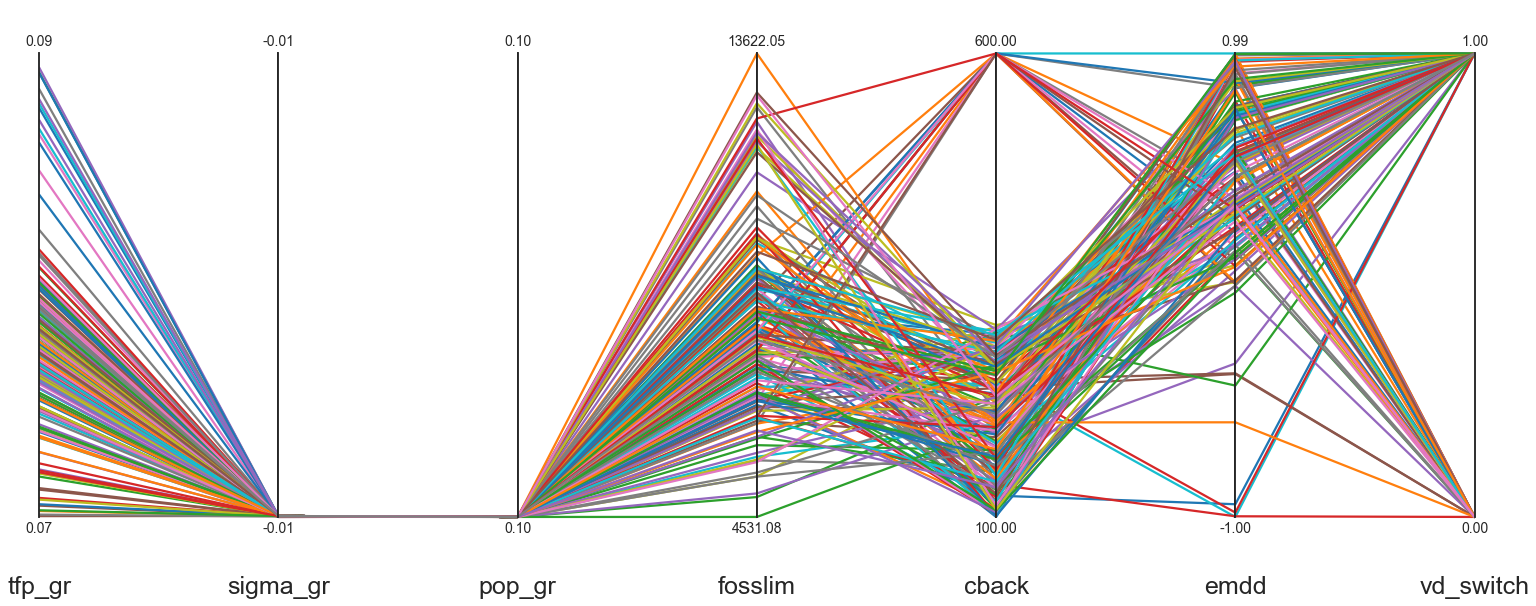

In [18]:
paraxes = parcoords.ParallelAxes(limits, rot=0)
paraxes.plot(data)
paraxes.fig.set_size_inches(25,10)
change_fontsize(paraxes, fs=25)
plt.show()
paraxes.fig.savefig(os.path.join(fig_path, str(run) + 'DSearch_parcoords' + '.png'), bbox_inches='tight')

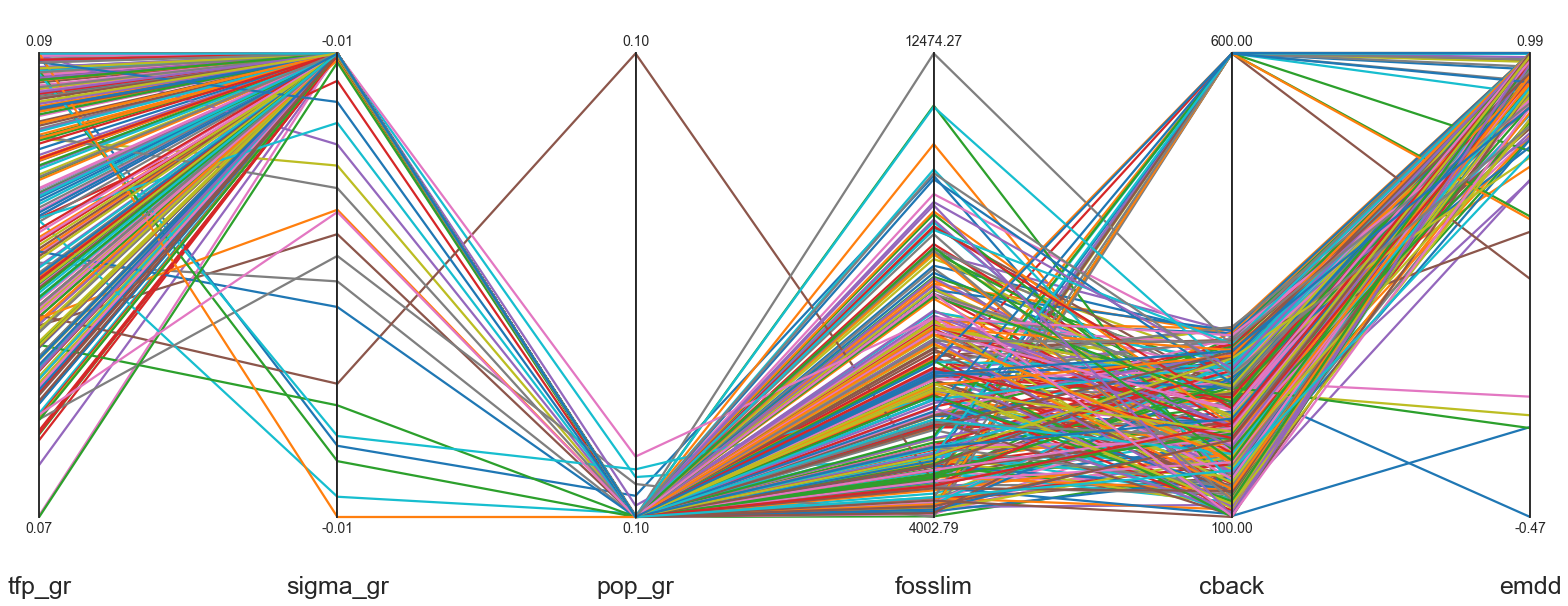

In [22]:
paraxes = parcoords.ParallelAxes(limits, rot=0)
paraxes.plot(data)
paraxes.fig.set_size_inches(25,10)
change_fontsize(paraxes, fs=25)
plt.show()
paraxes.fig.savefig(os.path.join(fig_path, str(run) + 'DSearch_parcoords' + '.png'), bbox_inches='tight')

In [ ]:
results

In [21]:
from ema_workbench.em_framework.optimization import (HyperVolume,EpsilonProgress)

convergence_metrics = [HyperVolume(minimum=[0.01,-0.001,0.00001,4000,100, -0.9999], maximum=[0.1, -0.0001,0.0001,13649,600, 0.9999]),EpsilonProgress()]

with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=1e3, searchover='levers', convergence=convergence_metrics, epsilons=[0.1,]*len(model.outcomes))

TypeError: 'PyDICE' object is not iterable

11/9/2020, 1:07 am

I am stuck here. Tried finding out what's sticking the cogs, but after 3 layers deep optimize inception functions I give up. 

Gotta ask Jan about this. The optimization code itself looks super interesting.
